In [21]:
# torch library
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as distrib 

# for example dataset 
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

# for plotting 
import matplotlib.pyplot as plt 
import sys, os 
from pathlib import Path
import json 

print('Packages imported')

Packages imported


In [11]:
# import all type hints you might need 
from typing import Callable

In [22]:
# load a couple of data sets 

main_path = Path(os.getcwd())

# --- MNIST
dataset_path = main_path.joinpath('mnist')
batch_size = 100 

def get_transforms(with_normalize=False) -> Callable:
    if not with_normalize:
        return transforms.Compose([
            transforms.ToTensor()])
    else:
       return transforms.Compose([
           transforms.ToTensor(),
           transforms.Normalize((0.1307,), (0.3081,))]) 

mnist_trans = get_transforms(True)

mnist_train_dataset = MNIST(dataset_path, transform=mnist_trans, train=True, download=True)
mnist_test_dataset = MNIST(dataset_path, transform=mnist_trans, train=False, download=True)
print('Done loading MNIST')
# ---

Done loading MNIST


In [70]:
''' 
Basic neural networks
    - feed forward networks 
    - convolutional networks
    - recurrent networks (RNN, LSTMS, ... )
    - transformers
'''

import abc 

# --- Basic neural networks --- 
class BaseNeuralNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, activation):
        super(BaseNeuralNet, self).__init__()

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.activation = activation
        self.output_dim = output_dim

        # (feature learning) hidden layers (stacking of multiple of hidden units + nonlinearity(per neuron) + batch_normalization + [dropouts] + [layer normalization])
        self.hidden_layers = None 
        self.fl = None
        
        self._init_hidden_layers()
        self._final_layer()

        # predict probablity
        self.prob_dist = nn.LogSoftmax(dim=1)

        
        assert self.hidden_layers is not None, 'Hidden layers are not initialized'
        assert self.fl is not None, 'Final layer is not initialized'


    @abc.abstractmethod
    def _init_hidden_layers(self): ...
    
    @abc.abstractmethod
    def _transform_input(self, x): ...

    @abc.abstractmethod
    def _final_layer(self): ...

    def forward(self, x):
        x = self._transform_input(x)
        x = self.hidden_layers(x) # this is the forward pass
        probs = self.prob_dist(self.fl(x))   # predicts the probablity as a multinomial distribution
        return probs


# --- Feed forward neural networks ---
class FeedForwardNeuralNet(BaseNeuralNet):
    def __init__(self, input_dim, hidden_dim, output_dim, activation):
        super(FeedForwardNeuralNet, self).__init__(input_dim, hidden_dim, output_dim, activation)

    def _init_hidden_layers(self):
        self.hidden_layers = nn.Sequential(
            nn.Linear(self.input_dim, self.hidden_dim, bias=False),               # what does bias do?
            self.activation,
            nn.Linear(self.hidden_dim, self.hidden_dim), 
            self.activation,
            nn.BatchNorm1d(self.hidden_dim),                          # what does batch normalization do?
            nn.Linear(self.hidden_dim, self.hidden_dim),
            self.activation,
            nn.BatchNorm1d(self.hidden_dim),
        )

    def _final_layer(self):
        # final hidden layer (linear classifier)
        self.fl = nn.Linear(self.hidden_dim, self.output_dim)

    def _transform_input(self, x):
        return x.flatten(start_dim=1)

# --- Convolutional neural networks ---
class ConvolutionalNeuralNet(BaseNeuralNet):
    def __init__(self, input_dim, hidden_dim, output_dim, activation):
        super(ConvolutionalNeuralNet, self).__init__(input_dim, hidden_dim, output_dim, activation)

    def _init_hidden_layers(self):
        self.hidden_layers = nn.Sequential(
            nn.Conv2d(self.input_dim, self.hidden_dim, kernel_size=3, stride=1, padding=1),   # what is hidden_dim, kernel_size, stride, padding?
            self.activation,
            nn.BatchNorm2d(self.hidden_dim),
            nn.Conv2d(self.hidden_dim, self.hidden_dim, kernel_size=3, stride=1, padding=1),
            self.activation,
            nn.BatchNorm2d(self.hidden_dim),
        )

    def _final_layer(self):
        # final hidden layer (linear classifier)
        self.fl = nn.Sequential(
            nn.Flatten(start_dim=1),
            nn.Linear(self.hidden_dim * 28 * 28, self.output_dim)
            )

    def _transform_input(self, x):
        return x

# --- Recurrent neural networks ---
# class RecurrentNeuralNet(BaseNeuralNet):
#     def __init__(self, input_dim, hidden_dim, output_dim, activation):
#         super(RecurrentNeuralNet, self).__init__(input_dim, hidden_dim, output_dim, activation)

#     def _init_hidden_layers(self):
#         return nn.LSTM(self.hidden_dim, self.hidden_dim, batch_first=True)

#     def _transform_input(self, x):
#         return x

print('Network definition is done.')

Network definition is done.


In [72]:
# How to train and eval a neural network

class NetworkTrainer:
    def __init__(self, optimizer, loss_fn, device):
        self.optimizer = optimizer
        self.loss_fn = loss_fn
        self.device = device

    def train_neural_net(self, model, train_loader, test_loader, epochs=10) -> None:
        print('Start model training ... ') 
        for epoch in range(epochs + 1):
            train_loss = self._train_step(model, train_loader)
            print(f'Epoch {epoch}: Train loss: {train_loss}')
            if epoch % 5 == 0:
                #test_loss = self.eval_neural_net(model, test_loader)
                accuracy = self._accuracy(model, test_loader)
                print('--------------------')
                print(f'Epoch {epoch}: correct classification rate : {accuracy * 100.}%')
                print('--------------------')
            

    def _train_step(self, model, train_loader):
        model.train()
        total_loss = 0
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(self.device), target.to(self.device)
            self.optimizer.zero_grad()  # removes any 
            output = model(data)
            loss = self.loss_fn(output, target)
            loss.backward()
            self.optimizer.step()
            total_loss += loss.item()

        # average loss over all batches 
        return total_loss / len(train_loader)


    def eval_neural_net(self, model, test_loader):
        model.eval()
        total_loss = 0
        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(self.device), target.to(self.device)
                output = model(data)
                total_loss += self.loss_fn(output, target).item()
        # 
        return total_loss / len(test_loader)

    def _accuracy(self, model, data_loader) -> torch.Tensor:
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for data, target in data_loader:
                data, target = data.to(self.device), target.to(self.device)
                output = model(data)
                _, predicted = torch.max(output.data, 1)
                total += target.size(0)
                correct += (predicted == target).sum().item()
        # 
        # FIXME: decompose this into precision, recall, balanced accuracy, f1-score, ...
        return correct / total


# --- Training a neural network ---
# check if cuda is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# select different datasets. 
train_dataset = mnist_train_dataset
test_dataset = mnist_test_dataset

# initalize data loaders
batch_size = 50

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# initalize the model
input_dim = 784         # input dimension
hidden_dim = 100        # feature dimension
output_dim = 10         # number of classification class
activation = nn.ReLU()  # activation function

#-- select model 
# feed-forward neural network
model = FeedForwardNeuralNet(input_dim, hidden_dim, output_dim, nn.ReLU()).to(device)

# convolutional neural network
# input_dim = 1
# hidden_dim = 32
# model = ConvolutionalNeuralNet(input_dim, hidden_dim, output_dim, nn.ReLU()).to(device)


# select optimizer and loss functions 
learning_rate = 0.001
epochs = 10
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
loss_fn = nn.NLLLoss()


# training config 
train_config = {
    'optimizer':{'optimizer_name': optimizer.__class__.__name__, 'learning_rate': learning_rate},
    'loss_fn': loss_fn.__class__.__name__,
    'device': device.type,
    'model' : {'model name': model.__class__.__name__, 'activation': activation.__class__.__name__},
    'train_details':{'epoch': epochs, 'batch_size': batch_size}
}

print('++ Training config ++')
print(json.dumps(train_config, indent=2))
print('\n')
# initalize the training loop

trainer = NetworkTrainer(optimizer, loss_fn, device)
trainer.train_neural_net(model, train_loader, test_loader, epochs=epochs)
print('Done training')


++ Training config ++
{
  "optimizer": {
    "optimizer_name": "SGD",
    "learning_rate": 0.001
  },
  "loss_fn": "NLLLoss",
  "device": "cuda",
  "model": {
    "model name": "FeedForwardNeuralNet",
    "activation": "ReLU"
  },
  "train_details": {
    "epoch": 10,
    "batch_size": 50
  }
}


Start model training ... 
Epoch 0: Train loss: 0.8854667714734872
--------------------
Epoch 0: correct classification rate : 90.13%
--------------------
Epoch 1: Train loss: 0.3969149890293678
Epoch 2: Train loss: 0.2989651184032361
Epoch 3: Train loss: 0.2473163445852697
Epoch 4: Train loss: 0.21541537963785232
Epoch 5: Train loss: 0.19210291732723514
--------------------
Epoch 5: correct classification rate : 95.28999999999999%
--------------------
Epoch 6: Train loss: 0.1733158221965035
Epoch 7: Train loss: 0.15868349133990706
Epoch 8: Train loss: 0.14578057656995952
Epoch 9: Train loss: 0.13385164672043173
Epoch 10: Train loss: 0.12387685552394638
--------------------
Epoch 10: correct cl



+++ Example activation functions with respect to forward/backward information flow +++




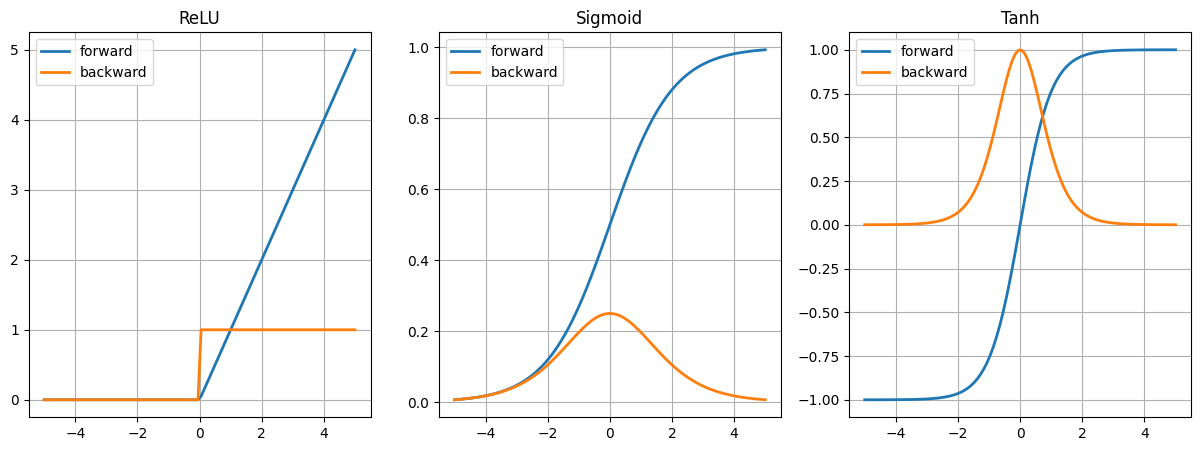

In [ ]:
# common good to keep in mind concepts introduced in neural networks.

##### activation functions

class Activation(nn.Module):
    def __init__(self, activation_name):
        super(Activation, self).__init__()
        self.activation_name = activation_name

    def get_grad(self, x) -> torch.Tensor:
        #if not x.requires_grad:
        x = x.clone().requires_grad_()
        out = self.forward(x)
        out.sum().backward()
        return x.grad

# few activation function
class Sigmoid(Activation):
    def __init__(self):
        super(Sigmoid, self).__init__('Sigmoid')

    def forward(self, x):
        #return torch.sigmoid(x)
        return  1 / (1 + torch.exp(-x))

class Tanh(Activation):
    def __init__(self):
        super(Tanh, self).__init__('Tanh')

    def forward(self, x):
        x_exp, neg_x_exp = torch.exp(x), torch.exp(-x)
        return (x_exp - neg_x_exp) / (x_exp + neg_x_exp)

class ReLU(Activation):
    def __init__(self):
        super(ReLU, self).__init__('ReLU')

    def forward(self, x):
        return torch.max(x, torch.tensor(0.))

# visualize activation functions
def plot_act(act_fns: list):
    x = torch.linspace(-5, 5, 100)
    _, ax = plt.subplots(1, len(act_fns), figsize=(15, 5))
    for c, act_fn in enumerate(act_fns):
        y = act_fn(x)
        ax[c].plot(x.numpy(), y.numpy(), linewidth=2, label='forward')
        ax[c].plot(x.numpy(), act_fn.get_grad(x).numpy(), linewidth=2, label='backward')
        ax[c].grid(True)
        ax[c].axis('tight')
        ax[c].legend()
        ax[c].set_title(act_fn.activation_name)
    print('\n')
    print('+++ Example activation functions with respect to forward/backward information flow +++')
    print('\n')
    plt.show()

plot_act([ReLU(), Sigmoid(), Tanh()])

    



In [ ]:
# Generative model + autoencoders. (VAE - variational auto encoders)

In [ ]:
# Applied ml (metric learning) --> select few examples. 